Loaded dataset with 36,238 rows and 17 columns.

Training Model A (64,32)...
Model A trained.

Training Model B (32,16)...
Model B trained.

=== Model A (64,32) ===
Train AUC: 0.933 | Valid AUC: 0.921
Train Acc: 0.865 | Valid Acc: 0.861
Precision: 0.836 | Recall: 0.716 | F1: 0.771
Confusion Matrix:
 [[4539  333]
 [ 675 1701]]
Classification Report:
               precision    recall  f1-score   support

Not Canceled       0.87      0.93      0.90      4872
    Canceled       0.84      0.72      0.77      2376

    accuracy                           0.86      7248
   macro avg       0.85      0.82      0.84      7248
weighted avg       0.86      0.86      0.86      7248


=== Model B (32,16) ===
Train AUC: 0.915 | Valid AUC: 0.912
Train Acc: 0.854 | Valid Acc: 0.854
Precision: 0.812 | Recall: 0.722 | F1: 0.764
Confusion Matrix:
 [[4474  398]
 [ 660 1716]]
Classification Report:
               precision    recall  f1-score   support

Not Canceled       0.87      0.92      0.89      4872


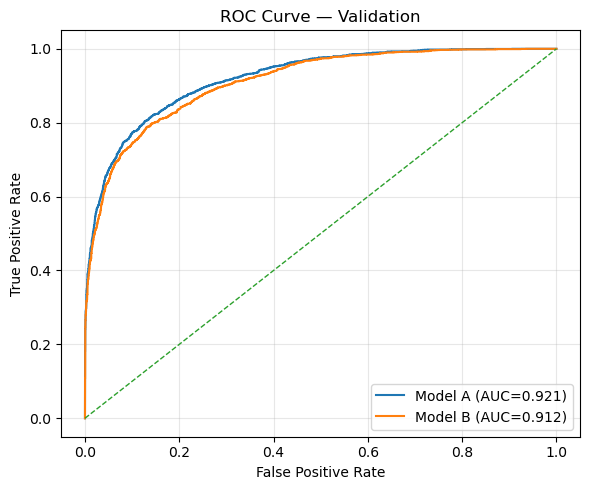

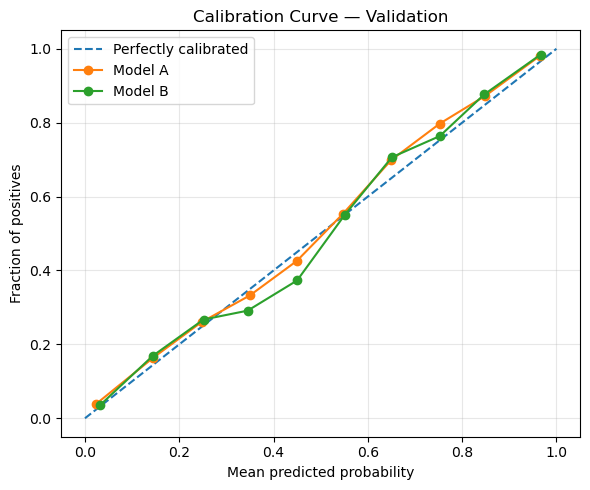


Selected Final Model: Model A (64,32)


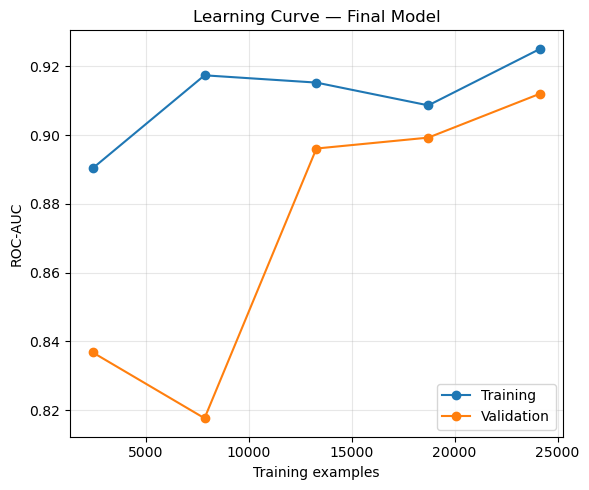

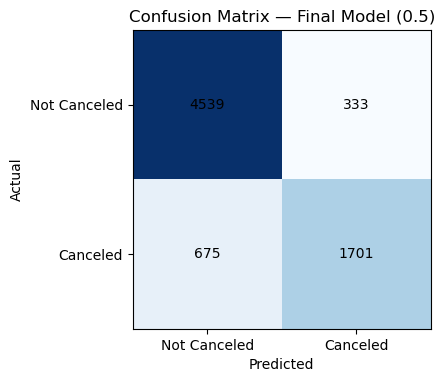


Top 20 features by permutation importance (AUC decrease):
   feature  importance_mean  importance_std
 feature_7         0.225909        0.002639
feature_14         0.129432        0.005684
 feature_9         0.088639        0.004287
feature_13         0.060826        0.003301
feature_16         0.053924        0.002040
feature_15         0.024885        0.000681
 feature_0         0.021880        0.000766
 feature_2         0.020049        0.000723
 feature_5         0.014594        0.000786
 feature_3         0.012806        0.001816
 feature_4         0.009673        0.000349
feature_10         0.009655        0.001910
 feature_6         0.007997        0.002147
 feature_1         0.005421        0.000989
feature_12         0.003179        0.000925
feature_11         0.000845        0.000313
 feature_8         0.000000        0.000000


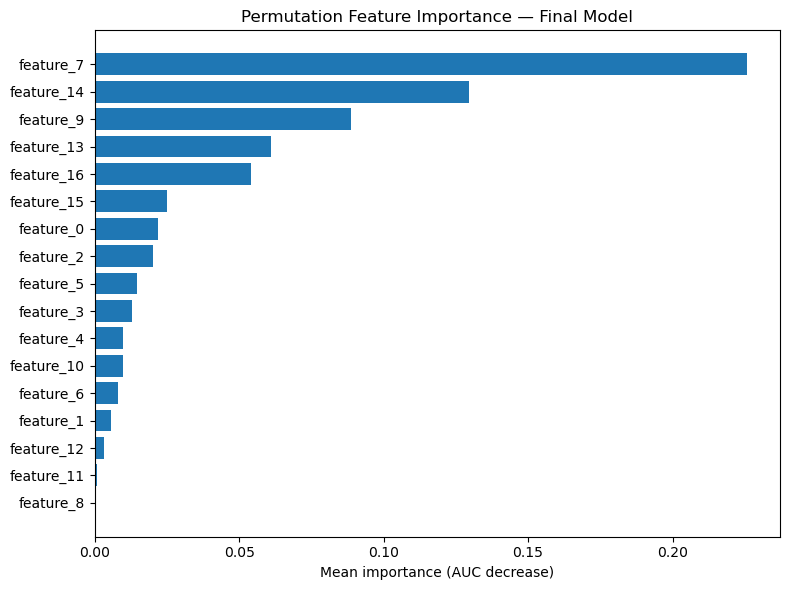


All artifacts saved to: /Users/thegootch/Desktop/Data Science/merrimack/ml_ai/project/artifacts
Figures saved: ['learning_curve_final_model.png', 'confusion_matrix.png', 'learning_curve_auc.png', 'roc_curve_A_vs_B.png', 'confusion_matrix_final.png', 'calibration_curve_A_vs_B.png', 'permutation_importance_top20.png', 'roc_curve_validation.png']


In [8]:
# ============================================================
# ABC Hotels — Booking Cancellation Prediction (Final, Condensed)
# Reproducible notebook: loads data, engineers features,
# compares 2 dense NNs, plots ROC & calibration, learning curve,
# computes permutation importance, saves artifacts.
# ============================================================
import warnings, os
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_curve
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

# ------------------ Config ------------------
CSV_PATH = "project_data.csv"   
RANDOM_STATE = 21
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = ARTIFACTS_DIR / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)

# ------------------ Load & Prepare ------------------
df = pd.read_csv(CSV_PATH)
print(f"Loaded dataset with {len(df):,} rows and {len(df.columns)} columns.")

if "Booking_ID" in df.columns:
    df = df.drop(columns=["Booking_ID"])

df["booking_status"] = df["booking_status"].astype(str).str.strip().str.lower().map({
    "canceled":1, "cancelled":1,
    "not_canceled":0, "not cancelled":0, "not-canceled":0, "not canceled":0
})
df = df.dropna(subset=["booking_status"])
df["booking_status"] = df["booking_status"].astype(int)

if "arrival_date" in df.columns:
    df["arrival_date"] = pd.to_datetime(df["arrival_date"], errors="coerce")
    df["arrival_month"] = df["arrival_date"].dt.month
    def _m2s(m):
        if pd.isna(m): return np.nan
        m = int(m)
        return "winter" if m in [12,1,2] else "spring" if m in [3,4,5] else "summer" if m in [6,7,8] else "fall"
    df["arrival_season"] = df["arrival_month"].map(_m2s)

y = df["booking_status"]
X = df.drop(columns=["booking_status"])

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
for c in ["type_of_meal_plan","room_type_reserved","market_segment_type","arrival_season"]:
    if c in X.columns and c not in cat_cols and not pd.api.types.is_numeric_dtype(X[c]):
        cat_cols.append(c)
num_cols = [c for c in X.columns if c not in cat_cols and pd.api.types.is_numeric_dtype(X[c])]

numeric_tf = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
onehot_args = {"handle_unknown":"ignore"}
if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames: onehot_args["sparse_output"]=False
else: onehot_args["sparse"]=False
categorical_tf = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(**onehot_args))])

preprocessor = ColumnTransformer([("num", numeric_tf, num_cols), ("cat", categorical_tf, cat_cols)], remainder="drop")

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

# ------------------ Models ------------------
mlp_A = MLPClassifier(hidden_layer_sizes=(64,32), activation="relu", solver="adam",
                      alpha=1e-4, batch_size=512, learning_rate="adaptive",
                      learning_rate_init=1e-3, max_iter=50, early_stopping=True,
                      validation_fraction=0.15, n_iter_no_change=5, random_state=RANDOM_STATE, verbose=False)

mlp_B = MLPClassifier(hidden_layer_sizes=(32,16), activation="relu", solver="adam",
                      alpha=5e-4, batch_size=256, learning_rate="adaptive",
                      learning_rate_init=1e-3, max_iter=75, early_stopping=True,
                      validation_fraction=0.15, n_iter_no_change=5, random_state=RANDOM_STATE, verbose=False)

pipe_A = Pipeline([("preprocessor", preprocessor), ("clf", mlp_A)])
pipe_B = Pipeline([("preprocessor", preprocessor), ("clf", mlp_B)])

print("\nTraining Model A (64,32)..."); pipe_A.fit(X_train, y_train); print("Model A trained.")
print("\nTraining Model B (32,16)..."); pipe_B.fit(X_train, y_train); print("Model B trained.")

# ------------------ Evaluation ------------------
def evaluate_model(pipeline, X_tr, y_tr, X_va, y_va, label="Model"):
    y_tr_proba = pipeline.predict_proba(X_tr)[:,1]
    y_va_proba = pipeline.predict_proba(X_va)[:,1]
    y_tr_pred = (y_tr_proba>=0.5).astype(int); y_va_pred = (y_va_proba>=0.5).astype(int)
    M = {}
    M["train_auc"] = roc_auc_score(y_tr, y_tr_proba)
    M["valid_auc"] = roc_auc_score(y_va, y_va_proba)
    M["train_acc"] = accuracy_score(y_tr, y_tr_pred)
    M["valid_acc"] = accuracy_score(y_va, y_va_pred)
    p,r,f1,_ = precision_recall_fscore_support(y_va, y_va_pred, average="binary", zero_division=0)
    M["valid_precision"], M["valid_recall"], M["valid_f1"] = p,r,f1
    M["confusion_matrix"] = confusion_matrix(y_va, y_va_pred)
    M["classification_report"] = classification_report(y_va, y_va_pred, target_names=["Not Canceled","Canceled"])
    print(f"\n=== {label} ===")
    print(f"Train AUC: {M['train_auc']:.3f} | Valid AUC: {M['valid_auc']:.3f}")
    print(f"Train Acc: {M['train_acc']:.3f} | Valid Acc: {M['valid_acc']:.3f}")
    print(f"Precision: {M['valid_precision']:.3f} | Recall: {M['valid_recall']:.3f} | F1: {M['valid_f1']:.3f}")
    print("Confusion Matrix:\n", M["confusion_matrix"])
    print("Classification Report:\n", M["classification_report"])
    return M, y_va_proba

metrics_A, y_valid_proba_A = evaluate_model(pipe_A, X_train, y_train, X_valid, y_valid, "Model A (64,32)")
metrics_B, y_valid_proba_B = evaluate_model(pipe_B, X_train, y_train, X_valid, y_valid, "Model B (32,16)")

pd.DataFrame([
    {"model":"A (64,32)", **{k:v for k,v in metrics_A.items() if k not in ["confusion_matrix","classification_report"]}},
    {"model":"B (32,16)", **{k:v for k,v in metrics_B.items() if k not in ["confusion_matrix","classification_report"]}},
]).to_csv(ARTIFACTS_DIR/"metrics_summary.csv", index=False)

# ------------------ ROC (A vs B) ------------------
fpr_A, tpr_A, _ = roc_curve(y_valid, y_valid_proba_A)
fpr_B, tpr_B, _ = roc_curve(y_valid, y_valid_proba_B)
plt.figure(figsize=(6,5))
plt.plot(fpr_A, tpr_A, label=f"Model A (AUC={metrics_A['valid_auc']:.3f})")
plt.plot(fpr_B, tpr_B, label=f"Model B (AUC={metrics_B['valid_auc']:.3f})")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Validation"); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(FIG_DIR/"roc_curve_A_vs_B.png", dpi=150); plt.show()

# ------------------ Calibration (A vs B) ------------------
prob_true_A, prob_pred_A = calibration_curve(y_valid, y_valid_proba_A, n_bins=10, strategy="uniform")
prob_true_B, prob_pred_B = calibration_curve(y_valid, y_valid_proba_B, n_bins=10, strategy="uniform")
plt.figure(figsize=(6,5))
plt.plot([0,1],[0,1],"--", label="Perfectly calibrated")
plt.plot(prob_pred_A, prob_true_A, marker="o", label="Model A")
plt.plot(prob_pred_B, prob_true_B, marker="o", label="Model B")
plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
plt.title("Calibration Curve — Validation"); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(FIG_DIR/"calibration_curve_A_vs_B.png", dpi=150); plt.show()

# ------------------ Select Final & Learning Curve ------------------
final_model = pipe_A
print("\nSelected Final Model: Model A (64,32)")

train_sizes, train_scores, valid_scores = learning_curve(
    final_model, X, y, cv=3, scoring="roc_auc",
    train_sizes=np.linspace(0.1,1.0,5), n_jobs=-1
)
plt.figure(figsize=(6,5))
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label="Training")
plt.plot(train_sizes, valid_scores.mean(axis=1), marker='o', label="Validation")
plt.xlabel("Training examples"); plt.ylabel("ROC-AUC"); plt.title("Learning Curve — Final Model")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR/"learning_curve_final_model.png", dpi=150); plt.show()

# ------------------ Confusion Matrix (thr=0.5) ------------------
y_valid_pred_final = (y_valid_proba_A >= 0.5).astype(int)
cm = confusion_matrix(y_valid, y_valid_pred_final)
plt.figure(figsize=(4.5,4.5))
plt.imshow(cm, cmap="Blues")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.xticks([0,1], ["Not Canceled","Canceled"]); plt.yticks([0,1], ["Not Canceled","Canceled"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix — Final Model (0.5)")
plt.tight_layout(); plt.savefig(FIG_DIR/"confusion_matrix_final.png", dpi=150); plt.show()

# ------------------ Permutation Importance ------------------
def get_feature_names_from_ct(ct: ColumnTransformer) -> list:
    names = []
    for name, transformer, cols in ct.transformers_:
        if name == "remainder" and transformer == "drop": continue
        if hasattr(transformer, "get_feature_names_out"):
            try: fn = transformer.get_feature_names_out(cols)
            except: fn = transformer.get_feature_names_out()
            names.extend(fn)
        elif hasattr(transformer, "steps"):
            last = transformer.steps[-1][1]
            if hasattr(last, "get_feature_names_out"):
                try: fn = last.get_feature_names_out(cols)
                except: fn = last.get_feature_names_out()
                names.extend(fn)
            else:
                names.extend(cols if isinstance(cols, list) else [cols])
        else:
            names.extend(cols if isinstance(cols, list) else [cols])
    return names

final_model.fit(X_train, y_train)
perm = permutation_importance(final_model, X_valid, y_valid, scoring="roc_auc",
                              n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1)
feat_names = get_feature_names_from_ct(final_model.named_steps["preprocessor"])
if len(feat_names) != len(perm.importances_mean):
    feat_names = [f"feature_{i}" for i in range(len(perm.importances_mean))]
imp_df = pd.DataFrame({"feature":feat_names,
                       "importance_mean":perm.importances_mean,
                       "importance_std":perm.importances_std}).sort_values("importance_mean", ascending=False)
imp_df.to_csv(ARTIFACTS_DIR/"permutation_importance_validation.csv", index=False)

print("\nTop 20 features by permutation importance (AUC decrease):")
print(imp_df.head(20).to_string(index=False))

plt.figure(figsize=(8,6))
top = imp_df.head(20)[::-1]
plt.barh(top["feature"], top["importance_mean"])
plt.xlabel("Mean importance (AUC decrease)")
plt.title("Permutation Feature Importance — Final Model")
plt.tight_layout(); plt.savefig(FIG_DIR/"permutation_importance_top20.png", dpi=150); plt.show()

# ------------------ Save reports ------------------
with open(ARTIFACTS_DIR/"classification_report_model_A.txt","w") as f: f.write(metrics_A["classification_report"])
with open(ARTIFACTS_DIR/"classification_report_model_B.txt","w") as f: f.write(metrics_B["classification_report"])

print(f"\nAll artifacts saved to: {ARTIFACTS_DIR.resolve()}")
print("Figures saved:", [p.name for p in FIG_DIR.iterdir()])
